In [1]:
# add trojan detecting chalange kit to path
import sys
sys.path.insert(0, '/root/course_project/tdc_starter_kit/')

In [107]:
import sys
print(sys.version)
# import solution
import importlib
# importlib.reload(solution)

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
print(torch.cuda.is_available())


import torch
import torchvision
import trojanvision
import trojanzoo
import argparse

# fix for torch transformer
class GELU(torch.nn.Module):
    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return torch.nn.functional.gelu(input)
torch.nn.modules.activation.GELU = GELU

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import shutil
import os
import torchvision
import matplotlib.pyplot as plt
import time
import copy
import random
import subprocess

from torchvision import transforms
import torch
from sklearn.decomposition import FastICA, PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm


from typing import TYPE_CHECKING
import argparse
from collections.abc import Callable
if TYPE_CHECKING:
    import torch.utils.data
import json
from tdc_starter_kit import utils

from collections import defaultdict
import pandas as pd
from functools import partial
from tqdm.notebook import tqdm
from torch.utils.data import Subset
seed = 77
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True


import trojanzoo_.torch_adopted.defenses.backdoor.training_filtering.activation_clustering_features
importlib.reload(trojanzoo_.torch_adopted.defenses.backdoor.training_filtering.activation_clustering_features)
ActivationClustering = trojanzoo_.torch_adopted.defenses.backdoor.training_filtering.activation_clustering_features.ActivationClustering


import diploma_utils
importlib.reload(diploma_utils)

3.10.0 | packaged by conda-forge | (default, Nov 20 2021, 02:24:10) [GCC 9.4.0]
True


<module 'diploma_utils' from '/root/course_project/diploma_utils.py'>

In [108]:
poisoned_path = "/root/poisoned_models/datasets/tdc_datasets/detection/train/trojan/id-{}/{}"


def load_specs():
    specifications = {}
    infos = {}
    for i in range(500):
        index = str(i).zfill(4)
        specifications[index] = torch.load(poisoned_path.format(index, 'attack_specification.pt'))
        with open(poisoned_path.format(index, 'info.json'), "r") as f:
            infos[index] = json.load(f)

    return specifications, infos

def load_models(keys):
    models = {}
    for key in keys:
        models[key] = torch.load(poisoned_path.format(key, 'model.pt'))
    return models


specifications, infos = load_specs()


def filter_by_dataset(dataset):
    return list(filter(
        lambda x: infos[x]['dataset'] == dataset,
        infos.keys()
    ))

def filter_by_trigger_type(trigger_type):
    return list(filter(
        lambda x: infos[x]['trigger_type'] == trigger_type,
        infos.keys()
    ))

keys = filter_by_dataset('GTSRB')
specifications = {key: specifications[key] for key in keys}
infos = {key: infos[key] for key in keys}

models = load_models(keys)
print(f"{len(models)=}")

len(models)=125


In [165]:
specifications['0313']

{'target_label': 24,
 'trigger': {'pattern': tensor([[[0.0136, 0.7233, 0.6711,  ..., 0.9787, 0.5772, 0.5636],
           [0.7999, 0.3793, 0.0045,  ..., 0.9679, 0.6604, 0.3484],
           [0.2694, 0.1480, 0.1565,  ..., 0.1676, 0.9462, 0.8137],
           ...,
           [0.8810, 0.9370, 0.9716,  ..., 0.8012, 0.4031, 0.3708],
           [0.9444, 0.0678, 0.5806,  ..., 0.6044, 0.7689, 0.8585],
           [0.0683, 0.0873, 0.7408,  ..., 0.1959, 0.8216, 0.6795]],
  
          [[0.4941, 0.5201, 0.0787,  ..., 0.0666, 0.0663, 0.9728],
           [0.1638, 0.3471, 0.7930,  ..., 0.6568, 0.3407, 0.3627],
           [0.0714, 0.1082, 0.0801,  ..., 0.6000, 0.7444, 0.4366],
           ...,
           [0.4277, 0.3870, 0.1093,  ..., 0.8933, 0.5645, 0.0345],
           [0.5022, 0.4943, 0.7986,  ..., 0.1360, 0.3526, 0.5908],
           [0.8287, 0.8127, 0.3938,  ..., 0.2316, 0.9258, 0.7648]],
  
          [[0.5756, 0.8949, 0.6307,  ..., 0.9968, 0.7000, 0.7570],
           [0.2551, 0.8412, 0.3270,  ..., 0.78

In [109]:
keys_by_trig_type = {
    "patch": filter_by_trigger_type("patch"),
    "blended": filter_by_trigger_type("blended")
} 

# отсортируем по размеру патча
keys_by_trig_type["patch"].sort(key=lambda x: torch.norm(specifications[x]["trigger"]['mask'], 1).item())

In [110]:
key = keys_by_trig_type["patch"][-1]

In [111]:
specifications[key]["trigger"]["mask"].sum(dim=2)

tensor([[ 0.,  0.,  0.,  0., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
         12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.]])

In [112]:
key = keys_by_trig_type["patch"][0]
info = infos[key]
model = models[key]
attack_specification = specifications[key]

print(json.dumps(info, indent=4))
print(f"{attack_specification['target_label']=}")

dataset, test_dataset, num_classes = utils.load_data(info["dataset"], folder="/root/datasets/")

{
    "attack_success_rate": 0.9581947743467933,
    "dataset": "GTSRB",
    "input_resolution": 32,
    "test_accuracy": 0.8829770387965162,
    "trigger_type": "patch"
}
attack_specification['target_label']=25


tensor(25)
tensor(0)


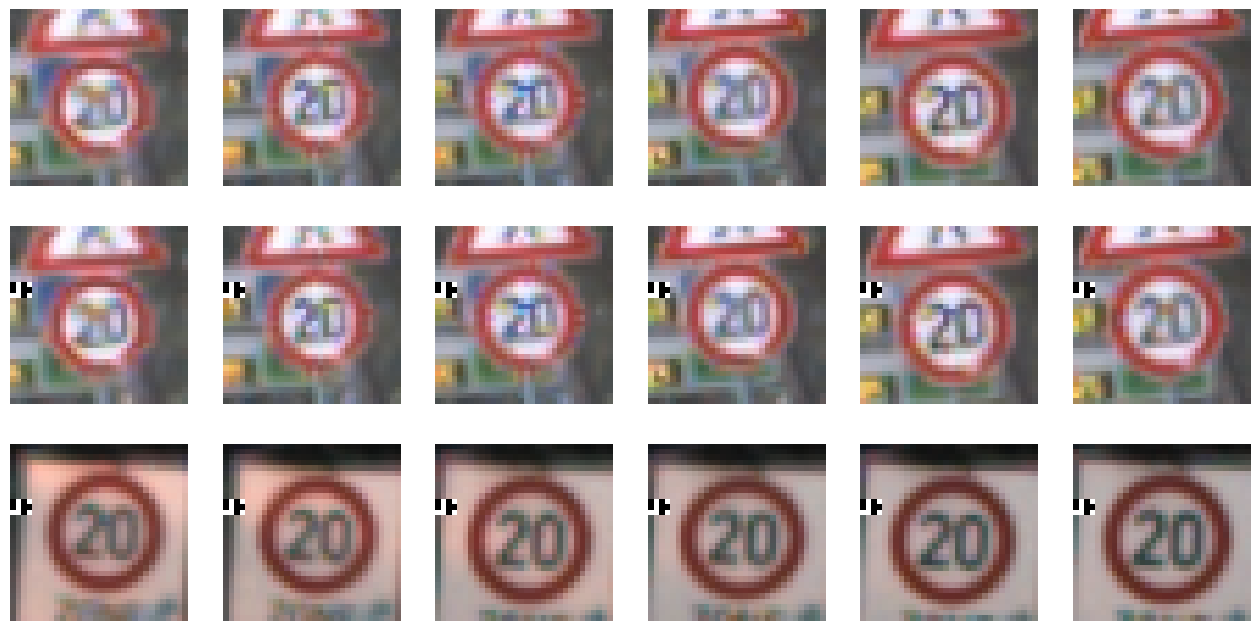

In [113]:
img = dataset[0][0]
# add trigger to image
img_with_trigger, _ = utils.insert_trigger(img, attack_specification)
print(model(img_with_trigger.unsqueeze(0)).argmax())
print(model(img.unsqueeze(0)).argmax())


fig, ax = plt.subplots(nrows=3, ncols=6, figsize=(16, 8))

for i in range(6):
    # First visualize an image without the trigger and with the trigger
    img = dataset[i][0].unsqueeze(0)
    attack_specification = attack_specification
    img_with_trigger, _ = utils.insert_trigger(img, attack_specification)
    ax[0, i].imshow(img.squeeze(0).permute(1,2,0).numpy())
    ax[0, i].axis('off')
    ax[1, i].imshow(img_with_trigger.squeeze(0).permute(1,2,0).numpy())
    ax[1, i].axis('off')
    # Now visualize another image with the same trigger
    img = dataset[100+i][0].unsqueeze(0)
    img_with_trigger, _ = utils.insert_trigger(img, attack_specification)
    ax[2, i].imshow(img_with_trigger.squeeze(0).permute(1,2,0).numpy())
    ax[2, i].axis('off')

plt.show()

In [114]:
nb_clusters = 2
nb_dims=10
batch_size = 100
num_epochs = 10  # for training

## Попробуем метод NeuralCleanse

In [ ]:
import trojanzoo_.torch_adopted.defenses.backdoor.model_inspection.neural_cleanse
importlib.reload(trojanzoo_.torch_adopted.defenses.backdoor.model_inspection.neural_cleanse)

NeuralCleanse = trojanzoo_.torch_adopted.defenses.backdoor.model_inspection.neural_cleanse.NeuralCleanse


dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

neural_cleanse = NeuralCleanse(model, list(range(10)), dataloader, img_shape=[1, 32, 32])

mask_list, pattern_list, loss_list, asr_list = neural_cleanse.detect()

In [ ]:
mask_list.shape

tensor(7, device='cuda:0')
tensor(5, device='cuda:0')


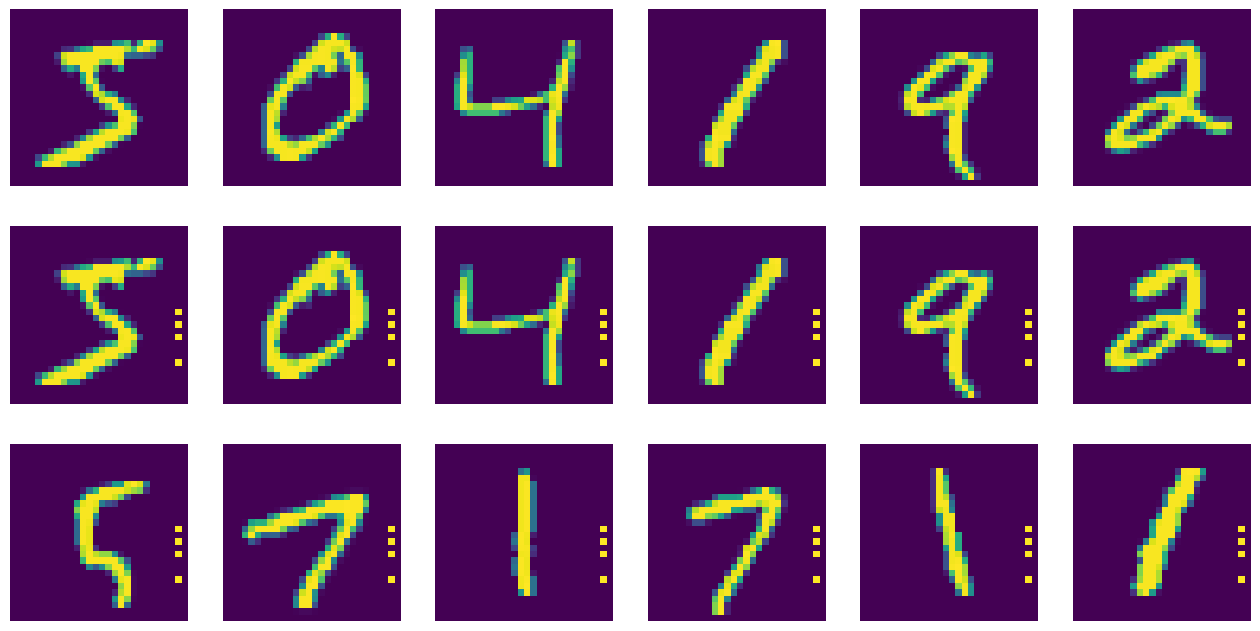

In [11]:
img = dataset[0][0].cuda()
target = 7
mask = mask_list[target]
pattern = pattern_list[target]

# add trigger to image
img_with_trigger = neural_cleanse.patch_images(img, mask, pattern)
print(model(img_with_trigger).argmax())
print(model(img.unsqueeze(0)).argmax())


fig, ax = plt.subplots(nrows=3, ncols=6, figsize=(16, 8))

for i in range(6):
    # First visualize an image without the trigger and with the trigger
    img = dataset[i][0].unsqueeze(0).cuda()
    attack_specification = attack_specification
    img_with_trigger = neural_cleanse.patch_images(img, mask, pattern)
    ax[0, i].imshow(img.squeeze(0).permute(1,2,0).cpu().numpy())
    ax[0, i].axis('off')
    ax[1, i].imshow(img_with_trigger.squeeze(0).permute(1,2,0).cpu().numpy())
    ax[1, i].axis('off')
    # Now visualize another image with the same trigger
    img = dataset[100+i][0].unsqueeze(0).cuda()
    img_with_trigger = neural_cleanse.patch_images(img, mask, pattern)
    ax[2, i].imshow(img_with_trigger.squeeze(0).permute(1,2,0).cpu().numpy())
    ax[2, i].axis('off')

plt.show()

In [19]:
key

'0426'

In [43]:
key = "0488"
info = infos[key]
model = models[key]
attack_specification = specifications[key]

target = 3

print(json.dumps(info, indent=4))
print(f"{attack_specification['target_label']=}")

dataset, test_dataset, num_classes = utils.load_data(info["dataset"], folder="/root/datasets/")



{
    "attack_success_rate": 0.9954,
    "dataset": "MNIST",
    "input_resolution": 28,
    "test_accuracy": 0.993,
    "trigger_type": "blended"
}
attack_specification['target_label']=3


In [45]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

neural_cleanse = NeuralCleanse(model, list(range(10)), dataloader, img_shape=[1, 28, 28])

mask, pattern, loss = neural_cleanse.optimize_mark(label=target)

    loss: 0.428         acc: 0.986          norm: 12.437        entropy: 0.039      time: 01:25


In [46]:
target=3

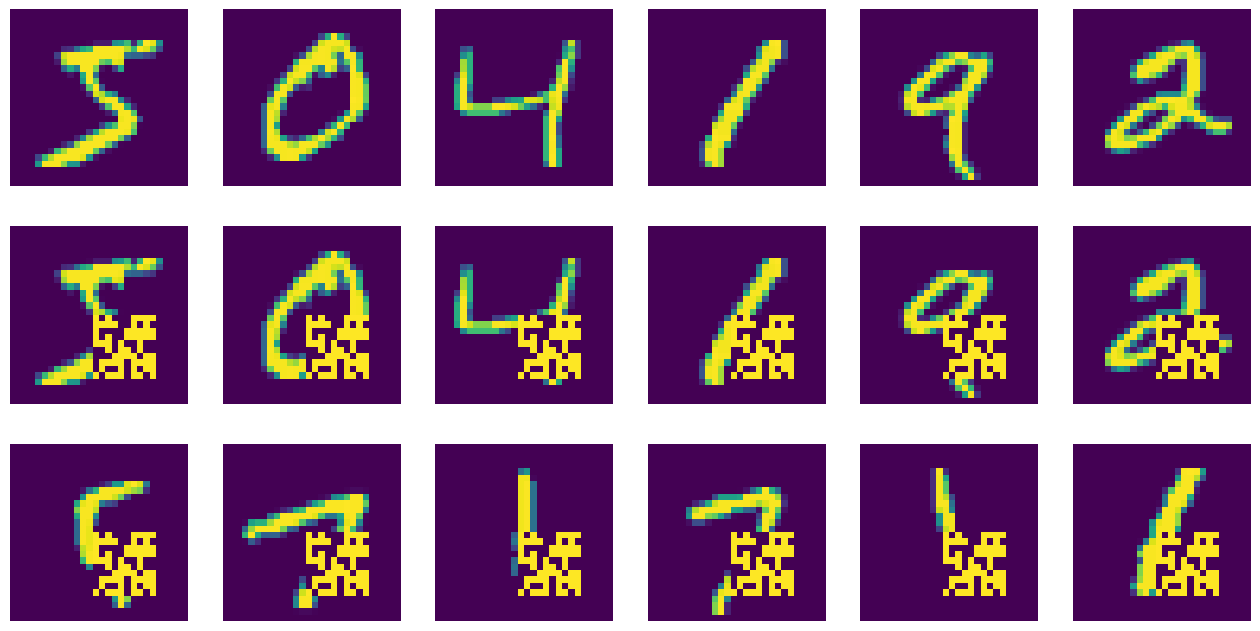

In [17]:
img = dataset[0][0]
# add trigger to image
fig, ax = plt.subplots(nrows=3, ncols=6, figsize=(16, 8))

for i in range(6):
    # First visualize an image without the trigger and with the trigger
    img = dataset[i][0].unsqueeze(0)
    attack_specification = attack_specification
    img_with_trigger, _ = utils.insert_trigger(img, attack_specification)
    ax[0, i].imshow(img.squeeze(0).permute(1,2,0).numpy())
    ax[0, i].axis('off')
    ax[1, i].imshow(img_with_trigger.squeeze(0).permute(1,2,0).numpy())
    ax[1, i].axis('off')
    # Now visualize another image with the same trigger
    img = dataset[100+i][0].unsqueeze(0)
    img_with_trigger, _ = utils.insert_trigger(img, attack_specification)
    ax[2, i].imshow(img_with_trigger.squeeze(0).permute(1,2,0).numpy())
    ax[2, i].axis('off')

plt.show()

In [18]:
key

'0426'

tensor(3, device='cuda:0')
tensor(5, device='cuda:0')


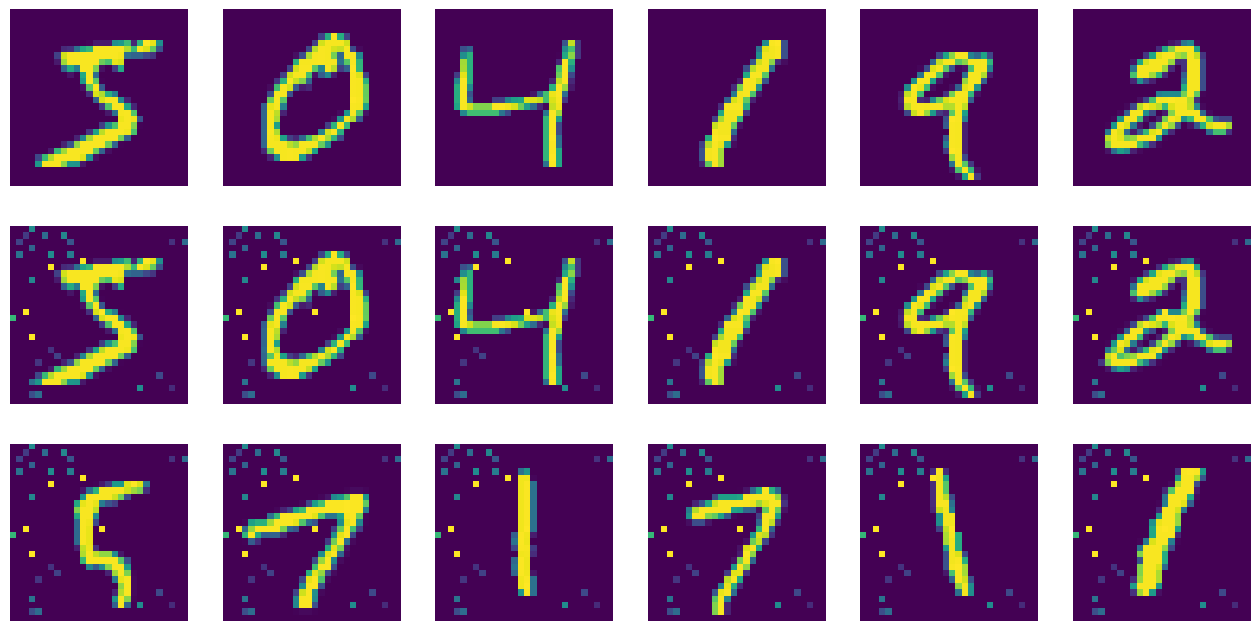

In [47]:
img = dataset[0][0].cuda()
# mask = mask_list[target]
# pattern = pattern_list[target]

# add trigger to image
img_with_trigger = neural_cleanse.patch_images(img, mask, pattern)
print(model(img_with_trigger).argmax())
print(model(img.unsqueeze(0)).argmax())


fig, ax = plt.subplots(nrows=3, ncols=6, figsize=(16, 8))

for i in range(6):
    # First visualize an image without the trigger and with the trigger
    img = dataset[i][0].unsqueeze(0).cuda()
    attack_specification = attack_specification
    img_with_trigger = neural_cleanse.patch_images(img, mask, pattern)
    ax[0, i].imshow(img.squeeze(0).permute(1,2,0).cpu().numpy())
    ax[0, i].axis('off')
    ax[1, i].imshow(img_with_trigger.squeeze(0).permute(1,2,0).cpu().numpy())
    ax[1, i].axis('off')
    # Now visualize another image with the same trigger
    img = dataset[100+i][0].unsqueeze(0).cuda()
    img_with_trigger = neural_cleanse.patch_images(img, mask, pattern)
    ax[2, i].imshow(img_with_trigger.squeeze(0).permute(1,2,0).cpu().numpy())
    ax[2, i].axis('off')

plt.show()

In [48]:
torch.norm(specifications[key]["trigger"]["pattern"] * specifications[key]["trigger"]["mask"] - pattern.cpu() * mask.cpu(), p=1)

tensor(387.5850)

In [26]:
specifications[key]["trigger"]["mask"].sum()

tensor(100.)

In [58]:
my_poisoned_img.shape

torch.Size([1, 1, 28, 28])

In [59]:
i = 2
img = dataset[i * 100 + i][0].cuda()
my_poisoned_img = neural_cleanse.patch_images(img, mask, pattern)[0]
original_poisoned_img, _ = utils.insert_trigger(dataset[i + 100*i][0], specifications[key])
torch.norm(my_poisoned_img.cuda() - original_poisoned_img.cuda(), p=1)

tensor(44.6595, device='cuda:0')

(-0.5, 27.5, 27.5, -0.5)

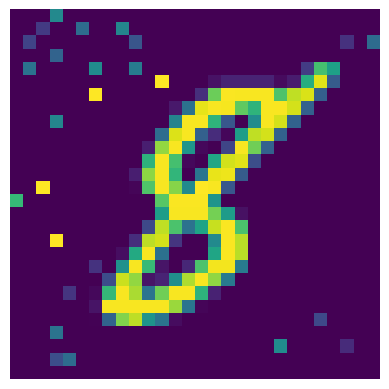

In [61]:
plt.imshow(my_poisoned_img.cpu().permute(1,2,0).numpy())
plt.axis('off')

In [63]:
import pickle

In [86]:
from tqdm.notebook import tqdm

In [117]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)


In [118]:
# посчитаем оптимизируемый функционал
 
with open("gtsrb_triggers_and_masks.pkl", "rb") as f:
    mnist_results = pickle.load(f)

In [119]:
def add_trigger(img, cluster_means, masks, triggers, means_without_trigger):
    trigger_id = torch.argmin(torch.norm(
        means_without_trigger - img.unsqueeze(0), dim=tuple(range(1, len(cluster_means.shape))), p=1)) # L1 metric
    trig_plus_image = img.cpu() * (1-masks[trigger_id].cpu()) + triggers[trigger_id].cpu() * masks[trigger_id].cpu()
    return trig_plus_image

In [120]:
l_part_patch = []
r_part_patch = []
l_part_blended = []
r_part_blended = []

good_cnt = 0

for attack_success_rate, target_class, key, masks, triggers, cluster_means in tqdm(mnist_results):
    if target_class != specifications[key]['target_label']:
        print("warning")
        continue
        
    
    l = torch.norm(
        triggers.cpu() * masks.cpu() -
        (specifications[key]["trigger"]["pattern"] * specifications[key]["trigger"]["mask"]).unsqueeze(0)
        ,
        p=1
    ) / masks.shape[0]
    
        
    
    means_without_trigger = cluster_means - triggers
    cur_r_part = 0
    already_tc = 0
    for img, cls in dataset:
        if cls == target_class:
            already_tc += 1
        else: 
            our_poisoned = add_trigger(img, cluster_means, masks, triggers, means_without_trigger)
            original_poisoned, _ = utils.insert_trigger(img, specifications[key])
            cur_r_part += torch.norm(our_poisoned - original_poisoned, p=1)
    
    
    if key in keys_by_trig_type["patch"]:
        l_part_patch.append(l)
        r_part_patch.append(cur_r_part / (len(dataset) -  already_tc))
    elif key in keys_by_trig_type["blended"]:
        l_part_blended.append(l)
        r_part_blended.append(cur_r_part / (len(dataset) -  already_tc))
    else:
        print(f"bad key {key}")
    

  0%|          | 0/114 [00:00<?, ?it/s]

warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning


In [121]:
print(f"{l_part / good_cnt=}")
print(f"{r_part / good_cnt=}")

l_part / good_cnt=tensor(inf)
r_part / good_cnt=tensor(inf)


In [122]:
nc_l_part_patch = []
nc_r_part_patch = []
nc_l_part_blended = []
nc_r_part_blended = []

good_cnt = 0

for attack_success_rate, target_class, key, masks, triggers, cluster_means in tqdm(mnist_results):
    if target_class != specifications[key]['target_label']:
        print("warning")
        continue
        
    good_cnt += 1
        
    neural_cleanse = NeuralCleanse(model, list(range(10)), dataloader, img_shape=[1, 32, 32], defense_remask_epoch=3)

    mask, pattern, loss = neural_cleanse.optimize_mark(label=target)
    l = torch.norm(
        pattern.cpu() * mask.cpu() -
        (specifications[key]["trigger"]["pattern"] * specifications[key]["trigger"]["mask"]).unsqueeze(0)
        ,
        p=1
    ) 
    
    cur_r_part = 0
    already_tc = 0
    for img, cls in dataset:
        if cls == target_class:
            already_tc += 1
        else: 
            nc_poisoned = neural_cleanse.patch_images(img.unsqueeze(0).cuda(), mask, pattern)
            original_poisoned, _ = utils.insert_trigger(img, specifications[key])
            cur_r_part += torch.norm(nc_poisoned.cpu() - original_poisoned.cpu(), p=1)
        
    if key in keys_by_trig_type["patch"]:
        nc_l_part_patch.append(l)
        nc_r_part_patch.append(cur_r_part / (len(dataset) -  already_tc))
    elif key in keys_by_trig_type["blended"]:
        nc_l_part_blended.append(l)
        nc_r_part_blended.append(cur_r_part / (len(dataset) -  already_tc))
    else:
        print(f"bad key {key}")
    

  0%|          | 0/114 [00:00<?, ?it/s]

    loss: 0.130         acc: 0.980          norm: 89.759        entropy: 0.076      time: 00:38
warning
    loss: 0.133         acc: 0.982          norm: 99.211        entropy: 0.075      time: 00:38
warning
warning
    loss: 0.138         acc: 0.982          norm: 105.609       entropy: 0.083      time: 00:37
warning
    loss: 0.142         acc: 0.981          norm: 94.738        entropy: 0.087      time: 00:38
warning
    loss: 0.161         acc: 0.979          norm: 95.994        entropy: 0.106      time: 00:37
warning
    loss: 0.138         acc: 0.983          norm: 102.181       entropy: 0.082      time: 00:38
warning
warning
warning
warning
warning
    loss: 0.148         acc: 0.979          norm: 92.909        entropy: 0.094      time: 00:38
warning
warning
    loss: 0.174         acc: 0.975          norm: 94.932        entropy: 0.117      time: 00:37
warning
    loss: 0.156         acc: 0.978          norm: 89.517        entropy: 0.102      time: 00:38
warning
warning
warning


In [124]:
l_patch = sum(l_part_patch) / len(l_part_patch)
r_patch = sum(r_part_patch) / len(r_part_patch)
l_blended = sum(l_part_blended) / len(l_part_blended)
r_blended = sum(r_part_blended) / len(r_part_blended)


l_nc_patch = sum(nc_l_part_patch) / len(nc_l_part_patch)
r_nc_patch = sum(nc_r_part_patch) / len(nc_r_part_patch)
l_nc_blended = sum(nc_l_part_blended) / len(nc_l_part_blended)
r_nc_blended = sum(nc_r_part_blended) / len(nc_r_part_blended)


print(f"{l_patch=}")
print(f"{r_patch=}")
print(f"{l_blended=}")
print(f"{r_blended=}")

print(f"{l_nc_patch=}")
print(f"{r_nc_patch=}")
print(f"{l_nc_blended=}")
print(f"{r_nc_blended=}")


print(f"{l_nc_patch / l_patch=}")
print(f"{r_nc_patch / r_patch=}")
print(f"{(l_nc_patch + r_nc_patch) / (l_patch + r_patch)=}")

print(f"{l_nc_blended / l_blended=}")
print(f"{r_nc_blended / r_blended=}")
print(f"{(l_nc_blended + r_nc_blended) / (l_blended + r_blended)=}")



l_patch=tensor(48.0883)
r_patch=tensor(180.0243)
l_blended=tensor(1458.5895)
r_blended=tensor(187.1705)
l_nc_patch=tensor(119.8894)
r_nc_patch=tensor(423.8554)
l_nc_blended=tensor(1471.3529)
r_nc_blended=tensor(421.9572)
l_nc_patch / l_patch=tensor(2.4931)
r_nc_patch / r_patch=tensor(2.3544)
(l_nc_patch + r_nc_patch) / (l_patch + r_patch)=tensor(2.3837)
l_nc_blended / l_blended=tensor(1.0088)
r_nc_blended / r_blended=tensor(2.2544)
(l_nc_blended + r_nc_blended) / (l_blended + r_blended)=tensor(1.1504)


In [128]:
len(l_part_blended)

16

In [95]:
(nc_l_part + nc_r_part) / (l_part + r_part)

tensor(1.2112)

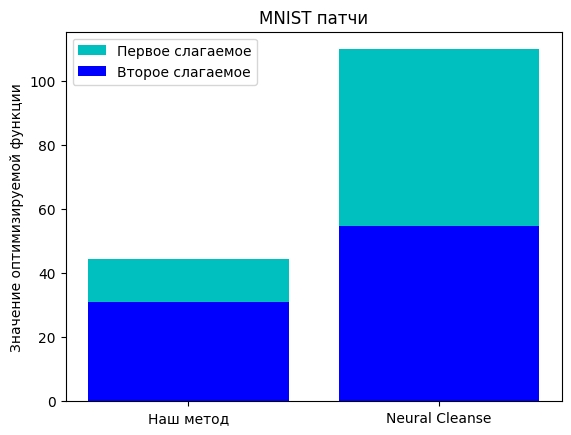

In [163]:
plt.title("MNIST патчи")

plt.bar("Наш метод", 13.4670, color="c", label="Первое слагаемое",  bottom=30.8758)
plt.bar("Наш метод", 30.8758, color="b", label="Второе слагаемое")



plt.bar("Neural Cleanse", 55.2956, color="c", bottom=54.5803)
plt.bar("Neural Cleanse", 54.5803, color="b")



plt.ylabel("Значение оптимизируемой функции")
plt.legend()


<BarContainer object of 1 artists>

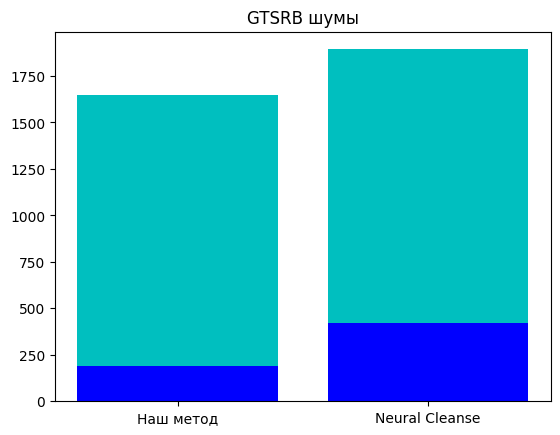

In [157]:
plt.title("GTSRB шумы")

plt.bar("Наш метод", 1458.5895, color="c", bottom=187.1705)
plt.bar("Наш метод", 187.1705, color="b")



plt.bar("Neural Cleanse", 1471.3529, color="c", bottom=421.9572)
plt.bar("Neural Cleanse", 421.9572, color="b")



# plt.ylabel("Значение оптимизируемой функции")


Text(0, 0.5, 'Значение оптимизируемой функции')

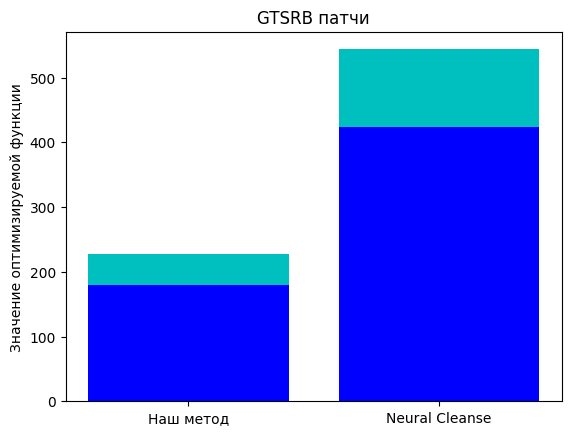

In [158]:
plt.title("GTSRB патчи")

plt.bar("Наш метод", 48.0883, color="c", bottom=180.0243)
plt.bar("Наш метод", 180.0243, color="b")



plt.bar("Neural Cleanse", 119.8894, color="c", bottom=423.8554)
plt.bar("Neural Cleanse", 423.8554, color="b")



plt.ylabel("Значение оптимизируемой функции")

<BarContainer object of 1 artists>

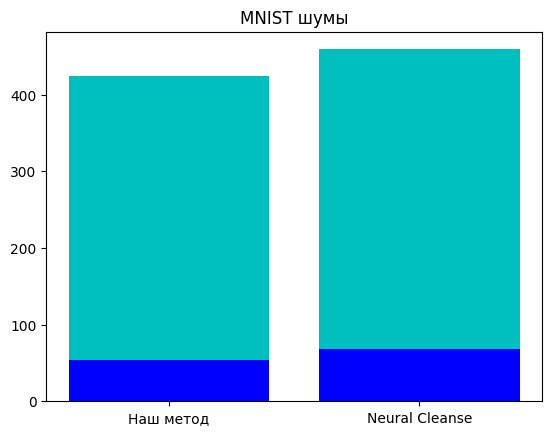

In [159]:
plt.title("MNIST шумы")

plt.bar("Наш метод", 369.7155, color="c", bottom=54.1498)
plt.bar("Наш метод", 54.1498, color="b")



plt.bar("Neural Cleanse", 391.3853, color="c", bottom=67.8660)
plt.bar("Neural Cleanse", 67.8660, color="b")



# plt.ylabel("Значение оптимизируемой функции")

Text(0, 0.5, 'Значение оптимизируемой функции')

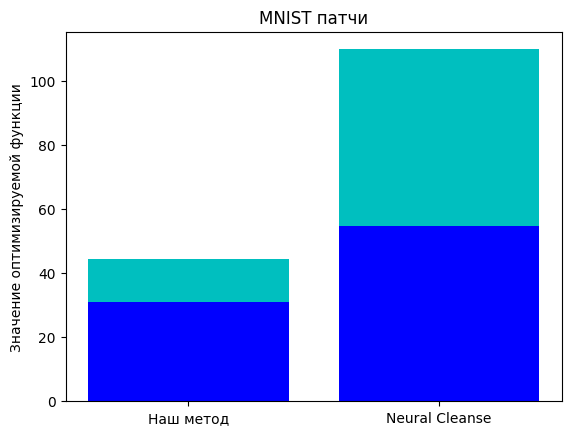

In [160]:
plt.title("MNIST патчи")

plt.bar("Наш метод", 13.4670, color="c", bottom=30.8758)
plt.bar("Наш метод", 30.8758, color="b")

plt.bar("Neural Cleanse", 55.2956, color="c", bottom=54.5803)
plt.bar("Neural Cleanse", 54.5803, color="b")

plt.ylabel("Значение оптимизируемой функции")